In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import lsst.sims.movingObjects as mo

In [3]:
orbitfile = 'NESCv9reintv1.TCO.withH.kep.des'
mini = mo.Orbits()
mini.readOrbits(orbitfile)
mini.orbits[0:5]

,objId,a,e,inc,Omega,argPeri,meanAnomaly,H,epoch,g,sed_filename
0,NESC0000001a,0.997277,0.032099,0.323426,283.584339,158.333342,306.015266,37.008092,60603.262969,0.15,S.dat
1,NESC000000B3,1.011793,0.006768,0.040201,208.493888,119.170625,271.591057,37.021498,54602.716701,0.15,S.dat
2,NESC000000C8,0.985949,0.027715,0.159922,155.755741,326.535489,64.935801,36.509016,55288.209681,0.15,S.dat
3,NESC000000GM,1.023415,0.019560,0.234426,97.532517,308.932078,187.279126,37.022154,58616.217523,0.15,S.dat
4,NESC000000J9,1.016520,0.012195,0.059523,357.285344,68.994836,115.973768,36.829602,59660.286367,0.15,S.dat


In [4]:
pyo = mo.PyOrbEphemerides()

In [5]:
import lsst.sims.maf.db as db

In [6]:
opsdb = db.OpsimDatabase('kraken_2026.db')

In [7]:
opsdb.fetchPropInfo()

({1: 'GalacticPlane',
  2: 'SouthCelestialPole',
  3: 'WideFastDeep',
  4: 'NorthEclipticSpur',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [4]})

In [8]:
nightlimit = 365 * 100
simData = opsdb.fetchMetricData(['fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos', 
                                 'fiveSigmaDepth', 'filter', 'seeingFwhmGeom'], 
                                sqlconstraint='night < %d and proposalId = 3' % (nightlimit))

In [41]:
import lsst.sims.photUtils as photUtils

In [50]:
lsst = {}
for f in ('u', 'g' , 'r', 'i', 'z', 'y'):
    lsst[f] = photUtils.Bandpass()
    lsst[f].readThroughput(os.path.join(os.getenv('LSST_THROUGHPUTS_DEFAULT'), 'total_' + f + '.dat'))
V = photUtils.Bandpass()
#os.listdir(os.path.join(os.getenv('SIMS_MOVINGOBJECTS_DIR'), 'data'))
V.readThroughput(os.path.join(os.getenv('SIMS_MOVINGOBJECTS_DIR'), 'data', 'harris_V.dat'))

In [80]:
colors = {}
ctype = photUtils.Sed()
ctype.readSED_flambda(os.path.join(os.getenv('SIMS_MOVINGOBJECTS_DIR'), 'data', 'S.dat'))
for f in ('u', 'g' , 'r', 'i', 'z', 'y'):
    colors[f] = ctype.calcMag(V) - ctype.calcMag(lsst[f])
    print(f, '%.3f' %colors[f])

u -1.863
g -0.369
r 0.263
i 0.457
z 0.400
y 0.407


In [81]:
v_equiv = np.zeros(len(simData), float)
for f in ('u', 'g' , 'r', 'i', 'z', 'y'):
    match = np.where(simData['filter'] == f)
    v_equiv[match] = simData['fiveSigmaDepth'][match] + colors[f]

Text(0.5,0,'Equivalent V band depth per filter (color corrected for S type)')

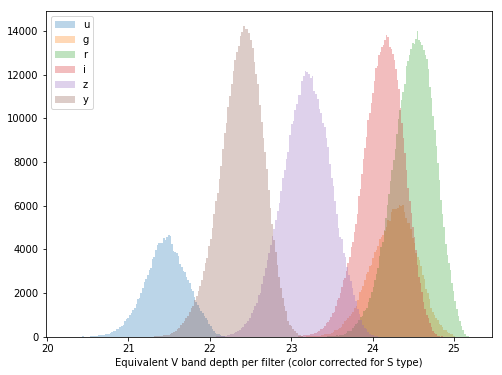

In [82]:
plt.figure(figsize=(8, 6))
for f in ('u', 'g' , 'r', 'i', 'z', 'y'):
    match = np.where(simData['filter'] == f)
    n, b, p = plt.hist(v_equiv[match], 100, alpha=0.3, label=f)
plt.legend(loc='upper left', fancybox=True, numpoints=1)
plt.xlabel("Equivalent V band depth per filter (color corrected for S type)") 

Text(0.5,0,'Five Sigma Depth per filter')

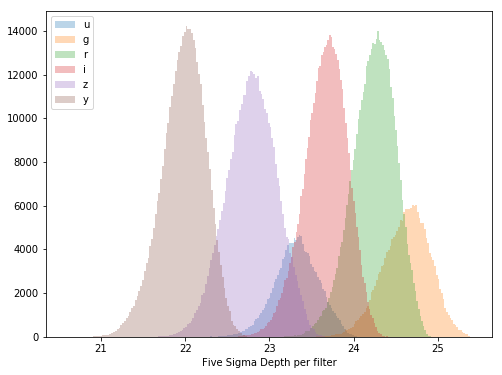

In [58]:
plt.figure(figsize=(8, 6))
for f in ('u', 'g' , 'r', 'i', 'z', 'y'):
    match = np.where(simData['filter'] == f)
    n, b, p = plt.hist(simData['fiveSigmaDepth'][match], 100, alpha=0.3, label=f)
plt.legend(loc='upper left', fancybox=True, numpoints=1)
plt.xlabel("Five Sigma Depth per filter")

In [9]:
sortIdx = np.argsort(simData['observationStartMJD'])
simData = simData[sortIdx]

In [10]:
tstep = 1.0
times = np.arange(int(simData['observationStartMJD'][0]) + 0.56, 
                  int(simData['observationStartMJD'][-1]) + 0.56 + tstep, 
                  tstep)
len(times)

3649

Text(0,0.5,'Fraction of population/dates')

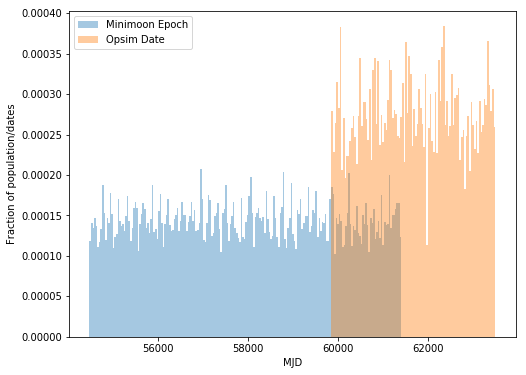

In [26]:
plt.figure(figsize=(8, 6))
n,b,p = plt.hist(mini.orbits.epoch, 200, density=True, alpha=0.4, label='Minimoon Epoch')
n,b,p = plt.hist(simData['observationStartMJD'], 100, density=True, alpha=0.4, label='Opsim Date')
plt.legend(loc='upper left', fancybox=True, numpoints=1)
plt.xlabel("MJD")
plt.ylabel('Fraction of population/dates')

In [29]:
print(simData['observationStartMJD'].min(), mini.orbits.epoch.max(), 
      (mini.orbits.epoch.max() - simData['observationStartMJD'].min())/365)

59853.016794 61405.5500411 4.25351574545


In [33]:
x = simData['observationStartMJD'].min() - 260
late = mini.orbits.query('epoch > @x')
len(late)

5232

In [58]:
%%timeit
ephs = pyo.generateEphemerides(times, timeScale='TAI', obscode='I11', ephMode='2body')

35.3 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [121]:
ephs = pyo.generateEphemerides(times, timeScale='TAI', obscode='I11', ephMode='2body')

In [71]:
np.diff(ephs['ra']*np.cos(np.radians(ephs['dec']))).max()

7.7325801556433014

In [72]:
np.diff(ephs['dec']).max()

2.8829690540305677

In [73]:
# Looks like objects can travel about 8 degrees per day (is there higher variation on shorter timescales?)

In [74]:
raTol = 10
decTol = 7

In [75]:
eph_idxs = np.searchsorted(ephs[0]['time'], simData['observationStartMJD'])

In [76]:
len(eph_idxs), len(simData), len(ephs[0])

(623453, 623453, 1094)

In [77]:
for i in (0, 1, 2, 3, 4, -1):
    print(ephs[0]['time'][eph_idxs[i]], simData['observationStartMJD'][i])

59853.56 59853.016794
59853.56 59853.0206366
59853.56 59853.021088
59853.56 59853.0215278
59853.56 59853.0219792
60946.56 60946.3950347


In [78]:
dts = ephs[0]['time'][eph_idxs] - simData['observationStartMJD']

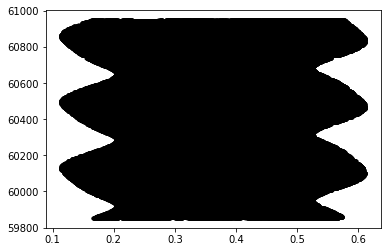

In [79]:
plt.plot(dts, simData['observationStartMJD'], 'k.')

In [83]:
dras = (ephs[0]['ra'][eph_idxs] - simData['fieldRA']) * np.cos(np.radians(simData['fieldDec']))
ddecs = (ephs[0]['dec'][eph_idxs] - simData['fieldDec'])

In [86]:
matchIdx = np.where((dras < raTol) & (ddecs < decTol))

In [89]:
len(matchIdx[0]), len(simData)

(118064, 623453)

In [94]:
time_acc = simData['observationStartMJD'][matchIdx]
len(time_acc)

118064

In [96]:
%%timeit
ephs = pyo.generateEphemerides(time_acc, timeScale='TAI', obscode='I11', ephMode='nbody')

12.1 s ± 378 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
ephs_acc = pyo.generateEphemerides(time_acc, timeScale='TAI', obscode='I11', ephMode='nbody')

In [98]:
(35.3/100 + 12) * 20000 / 60. / 60. 

68.62777777777778

In [103]:
# Then check what is really in fov? 
from lsst.sims.utils import angularSeparation

In [106]:
sep = angularSeparation(ephs_acc['ra'], ephs_acc['dec'], simData['fieldRA'][matchIdx], simData['fieldDec'][matchIdx])

In [109]:
sep.max(), sep.min()

(179.79016681290727, 0.10970210680756547)

In [110]:
accMatchIdx = np.where(sep < 2.1)

In [111]:
len(accMatchIdx[0])

93

In [117]:
fephs = ephs_acc[0][accMatchIdx]

In [119]:
fephs['magV']

array([ 37.33056666,  37.32565026,  31.91883082,  31.95051175,
        31.95146478,  32.01076165,  32.01078091,  32.01124576,
        32.01126605,  32.04238469,  32.0424044 ,  32.04290912,
        32.04339749,  32.13677374,  32.13751594,  32.13757527,
        32.13817401,  32.16907173,  32.16966973,  32.20070793,
        32.20138792,  32.26330566,  32.26411595,  32.35517469,
        32.35530286,  32.35610341,  32.35623843,  32.41596286,
        32.41691657,  32.50271069,  32.50321685,  32.6744164 ,
        32.69683777,  32.74993981,  32.74995599,  32.75061583,
        32.75063265,  32.77539006,  32.77540518,  32.77552908,
        32.77597443,  32.77599056,  32.77611934,  32.82693251,
        32.87756934,  32.87759982,  32.87834405,  32.87837642,
        32.90250044,  32.95204466,  32.97664037,  32.97666996,
        33.00107158,  33.00110157,  33.04895552,  33.04955804,
        33.0956765 ,  33.09576164,  33.09635497,  33.09644411,
        33.14146075,  33.14210597,  33.2071849 ,  33.20

In [123]:
ephs['magV'].min()

28.098116774930414

In [34]:
bright_objs = []
tstep = 2.0
times = np.arange(54466, 61406 + tstep/2., tstep)
pyo = mo.PyOrbEphemerides()
for i, obj in enumerate(mini):
    pyo.setOrbits(obj)
    ephs = pyo.generateEphemerides(times, timeScale='TAI', obscode='I11', ephMode='2body')
    if (ephs[0]['magV'].min() < 26.5):
        bright_objs.append(i)

In [35]:
len(mini), len(bright_objs)

(20265, 1342)

In [36]:
br = mini[bright_objs]

Text(0,0.5,'Number of objects')

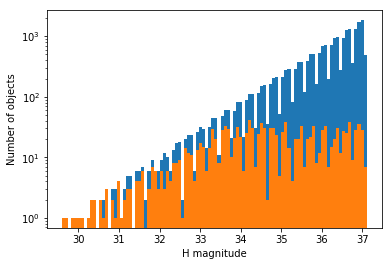

In [37]:
plt.figure()
n, b, p = plt.hist(mini.orbits.H, bins=100)
n, b, p = plt.hist(br.orbits.H, bins=b)
plt.semilogy()
plt.xlabel('H magnitude')
plt.ylabel('Number of objects')

Text(0,0.5,'Number of objects')

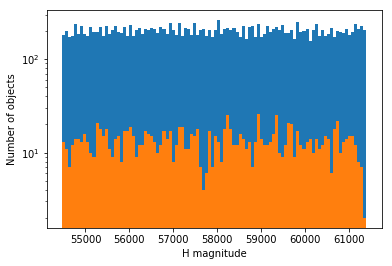

In [38]:
plt.figure()
n, b, p = plt.hist(mini.orbits.epoch, bins=100)
n, b, p = plt.hist(br.orbits.epoch, bins=b)
plt.semilogy()
plt.xlabel('H magnitude')
plt.ylabel('Number of objects')

In [79]:
br.orbits.to_csv('allbright_NESCv9reintv1.TCO.withH.kep.des', index=False, sep=' ')